Take the math genealogy graph and modify it in different formats to apply classification

1) Node division (considered for all methods)
2) Data for probabilistic graph inference
3) Data for Text classification (BERT and NB)
4) Data for GNN (GCN)

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import nltk
import pandas as pd
import seaborn as sns

In [2]:
# delimitar nombre y ubicacion del grafo a tomar
carpeta_datos =  '.\\nx_data\\'
nombre_grafo = "genealogy_nx_graph.json"

### Leer el grafo

In [3]:
with open(carpeta_datos + nombre_grafo, 'rb') as f:
    grafo_original = pickle.load(f)

In [4]:
# responder preguntas basicas
num_nodos = grafo_original.number_of_nodes()
num_aristas = grafo_original.number_of_edges()

print(f"Se tienen {num_nodos} nodos y {num_aristas} aristas")

Se tienen 297377 nodos y 329209 aristas


In [5]:
# trabajar con una copia, por si se quiere el original otra vez
grafo = grafo_original.copy()

# 1) Select and divide data

Comenzar a adaptar los datos para hacer clasificacionde subjects basados en la tesis.
Solo se van a considerar matematicos con tesis. Se conservan matematicos con tesis y sin subjects, aunque no puedan ayudar al entrenamiento, ni a la prueba, pueden servir en los metodos de grafo para que la informacion fluya de un nodo a otro. Estos nodos que no tienen subject y solo estan para los metodos de grafo son considerados nodos useless.


Dividir nodos en train/val/test/useless.



In [6]:
# nombre del archivo a crear con la division de nodos
file_output_division = "./node_division.json"

### Ver disponibilidad de informacion

In [7]:
# guardar todos los ids
ids_matematicos = []

# guardar los id's de los matematicos con informacion faltante
ids_no_thesis = []
ids_no_subject = []

# iterar en los matematicos
for id_mat, info_mat in grafo.nodes(data=True):
    
    # guardar su id
    ids_matematicos.append(id_mat)
    
    ## INRORMACION FALTANTE

    # checar si no tiene thesis
    if info_mat['thesis'] is None:
        ids_no_thesis.append(id_mat)
    
    # checar si no tiene subject
    if info_mat['subject'] is None:
        ids_no_subject.append(id_mat)

# hacer que las listas sean conjuntos
set_ids_matematicos= set(ids_matematicos)
set_ids_no_thesis  = set(ids_no_thesis)
set_ids_no_subject = set(ids_no_subject)


# hacer complementos
set_ids_thesis =  set_ids_matematicos - set_ids_no_thesis
set_ids_subject = set_ids_matematicos - set_ids_no_subject

In [8]:
# hacer un df con la informacion
# de los numero de matematicos con ciertas caracteristicas
data = {'Sin subject': [None, None], 'Con subject': [None, None]}
df_num_inf_faltante = pd.DataFrame(data, index=['Sin tesis', 'Con tesis'])

# llenar el df

# 1: sin tesis, sin subject
df_num_inf_faltante.loc['Sin tesis', 'Sin subject'] = len(set_ids_no_thesis & set_ids_no_subject)
# 2: sin tesis, con subject
df_num_inf_faltante.loc['Sin tesis', 'Con subject'] = len(set_ids_no_thesis & set_ids_subject)
# 3: con tesis, sin subject
df_num_inf_faltante.loc['Con tesis', 'Sin subject'] = len(set_ids_thesis & set_ids_no_subject)
# 4: con tesis, con subject
df_num_inf_faltante.loc['Con tesis', 'Con subject'] = len(set_ids_thesis & set_ids_subject)

print(f"Frecuencias de los {df_num_inf_faltante.sum().sum()} matematicos segun su informacion")
df_num_inf_faltante

Frecuencias de los 297377 matematicos segun su informacion


,Sin subject,Con subject
Sin tesis,20964,8639
Con tesis,93273,174501


In [9]:
# ver en porcentaje

# hacer una matriz de porcentajes
df_porcenajes_inf_faltante = 100*df_num_inf_faltante/len(set_ids_matematicos)
# redondea todos los elementos a un decimal
df_porcenajes_inf_faltante = df_porcenajes_inf_faltante.map(lambda x: round(x, 1))

print("Porcentaje de matematicos segun su informacion")
df_porcenajes_inf_faltante

Porcentaje de matematicos segun su informacion


,Sin subject,Con subject
Sin tesis,7.0,2.9
Con tesis,31.4,58.7


In [10]:
# unicamente ver division de sin o con tesis
pd.DataFrame(df_num_inf_faltante.sum(axis=1)).rename(columns={0: 'Num'}, inplace=False)

,Num
Sin tesis,29603
Con tesis,267774


In [11]:
# unicamente ver division de sin o con tesis
pd.DataFrame(df_porcenajes_inf_faltante.sum(axis=1)).rename(columns={0: 'Porcentaje'}, inplace=False)

,Porcentaje
Sin tesis,9.9
Con tesis,90.1


## Solo conservar nodos con tesis

In [12]:
# tomarlos del grafo
nodos_considerar = np.array([v for v, info_v in grafo.nodes(data=True) if info_v['thesis'] is not None])

print(f"Tomar los {len(nodos_considerar)} que tienen thesis")

Tomar los 267774 que tienen thesis


In [13]:
# tomar el subject de cada uno
subjects_considerar = np.array([grafo.nodes()[v]['subject'] for v in nodos_considerar])

print(f"Tomar los {len(subjects_considerar)} subjects correspondientes")

Tomar los 267774 subjects correspondientes


## Identificar nodos sin subject (Useless)

In [14]:
# identificar el useless mask, los que no tienen subject
useless_mask = (subjects_considerar == None)

# tomar los nodos useless
nodos_useless = nodos_considerar[useless_mask]

print(f"Se tienen {len(nodos_useless)} nodos useless")

# comprobar que los subjects de estos sean None
subjects_considerar[useless_mask]

Se tienen 93273 nodos useless


array([None, None, None, ..., None, None, None], dtype=object)

## Identificar nodos utiles

In [15]:
# se rescatan los nodos que no son useless
nodos_utiles = nodos_considerar[~useless_mask]

# tomar sus subjects
subjects_utiles = subjects_considerar[~useless_mask]

print(f"Esto nos deja con {len(nodos_utiles)} nodos utiles")

Esto nos deja con 174501 nodos utiles


In [16]:
# hacer un df con esta informacion
df_util = pd.DataFrame()
df_util['nodo'] = nodos_utiles
df_util['subject'] = subjects_utiles

# agregar una columna que nos diga la division (tran/val/test)
df_util['division'] = ['NADA'] * len(nodos_utiles)

# ver
df_util.head()

,nodo,subject,division
0,255897,68—Computer science,NADA
1,206917,"91—Game theory, economics, social and behavior...",NADA
2,113793,"78—Optics, electromagnetic theory",NADA
3,113794,"78—Optics, electromagnetic theory",NADA
4,113795,"78—Optics, electromagnetic theory",NADA


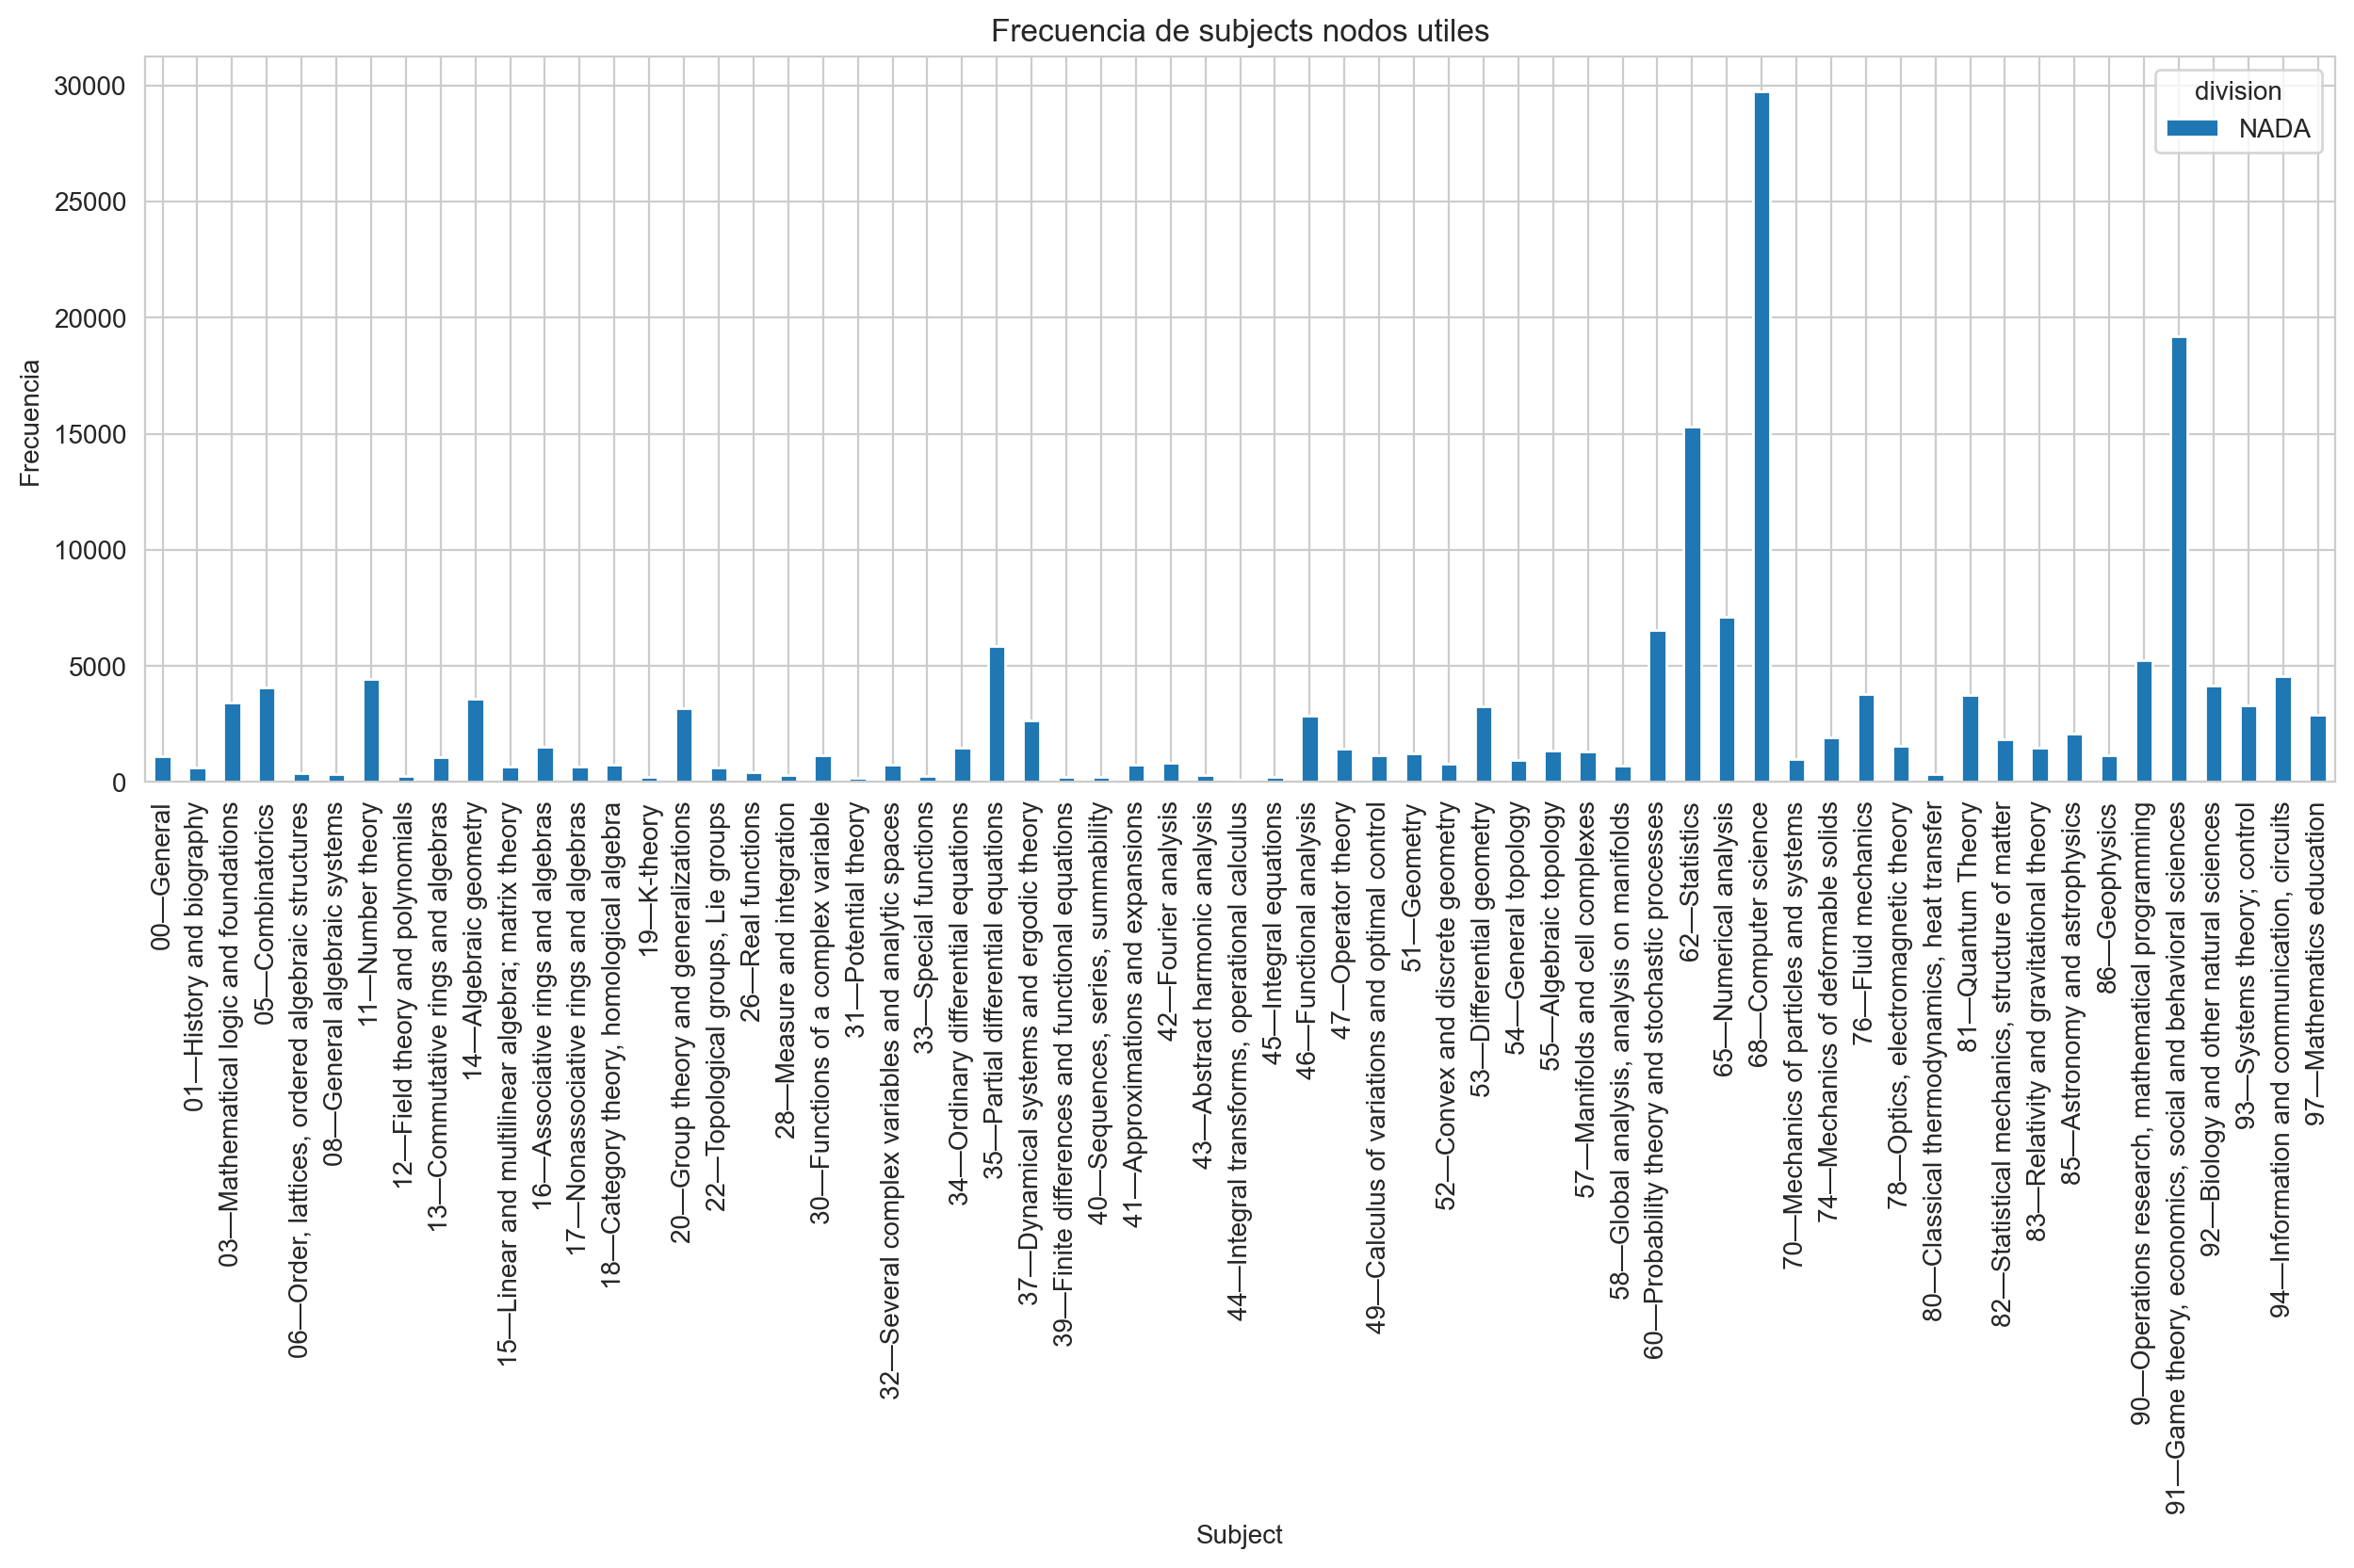

In [17]:
sns.set_style("whitegrid")

# hacer la figura de distribucion de etiquetas
fig, ax = plt.subplots(figsize=(15, 5), dpi = 200)

# pasar como pivot table
pivot_df = df_util.pivot_table(index='subject', columns='division', aggfunc='size')
# invertir el orden
pivot_df = pivot_df[pivot_df.columns[::-1]]
# hacer las barras
pivot_df.plot(kind='bar', stacked=True, ax=ax)

# titulos
ax.set_title('Frecuencia de subjects nodos utiles')
ax.set_xlabel('Subject')
ax.set_ylabel('Frecuencia')

plt.show()

In [18]:
# ver las clases con menos datos
pivot_df.sort_values('NADA').head()

division,NADA
subject,
"44—Integral transforms, operational calculus",96
31—Potential theory,165
45—Integral equations,201
"40—Sequences, series, summability",210
39—Finite differences and functional equations,217


## Dividir en train/val/test

In [19]:
# delimitar porcentajes

porcentaje_train = 0.8
porcentaje_val = 0.1
porcentaje_test = 0.1

# ver que si sumen a 1
assert porcentaje_train + porcentaje_val + porcentaje_test == 1

In [20]:
from sklearn.model_selection import train_test_split

# dividir los nodos restantes en train, val, y test


# primero dividir los nodos utiles train_val y test
# intentar hacer con stratify

try:
    df_train_val, df_test, = train_test_split(df_util,
                                              test_size = porcentaje_test,
                                              stratify = df_util['subject'],
                                              random_state= 42)
    
    print("Se hace la division de train_val y test con stratify")
    
except Exception as e:
    df_train_val, df_test, = train_test_split(df_util,
                                              test_size = porcentaje_test,
                                              random_state= 42)
    
    print("WARNING: Se hace la division de train_val y test sin stratify")
    
    
# despues se divide train_val en train y val
# intentar hacer con stratify

# calcular el porcentaje que requiere val dentro de train_val
porcentaje_division = porcentaje_val/(porcentaje_val + porcentaje_train)

try:
    
    df_train, df_val, = train_test_split(df_train_val,
                                         test_size = porcentaje_test, # realmente el val size
                                         stratify = df_train_val['subject'],
                                         random_state= 42)
    
    print("Se hace la division de train y val con stratify")
    
except Exception as e:
    
    
    df_train, df_val, = train_test_split(df_train_val,
                                         test_size = porcentaje_test, # realmente el val size
                                         random_state= 42)
    
    print("WARNING: Se hace la division de train y val sin stratify")

Se hace la division de train_val y test con stratify
Se hace la division de train y val con stratify


In [21]:
# tomar los nodos de cada division
nodos_train = df_train['nodo'].values
nodos_val = df_val['nodo'].values
nodos_test = df_test['nodo'].values

In [22]:
# ver las proporciones de nodos utiles
# ver los porcentajes creados

print(f"Train nodes: {len(nodos_train)} nodos - {round(100* len(nodos_train)/len(nodos_considerar), 2)}%")
print(f"Val nodes: {len(nodos_val)} nodos - {round(100* len(nodos_val)/len(nodos_considerar), 2)}%")
print(f"Test nodes: {len(nodos_test)} nodos - {round(100* len(nodos_test)/len(nodos_considerar), 2)}%")
print(f"\nUseless nodes: {len(nodos_useless)} nodos - {round(100* len(nodos_useless)/len(nodos_considerar), 2)}%")

Train nodes: 141345 nodos - 52.79%
Val nodes: 15705 nodos - 5.87%
Test nodes: 17451 nodos - 6.52%

Useless nodes: 93273 nodos - 34.83%


In [23]:
# indicarl en el df de nodos utiles a que pertenecen
df_util.loc[df_util['nodo'].isin(nodos_train), 'division'] = "train"
df_util.loc[df_util['nodo'].isin(nodos_val), 'division'] = "val"
df_util.loc[df_util['nodo'].isin(nodos_test), 'division'] = "test"

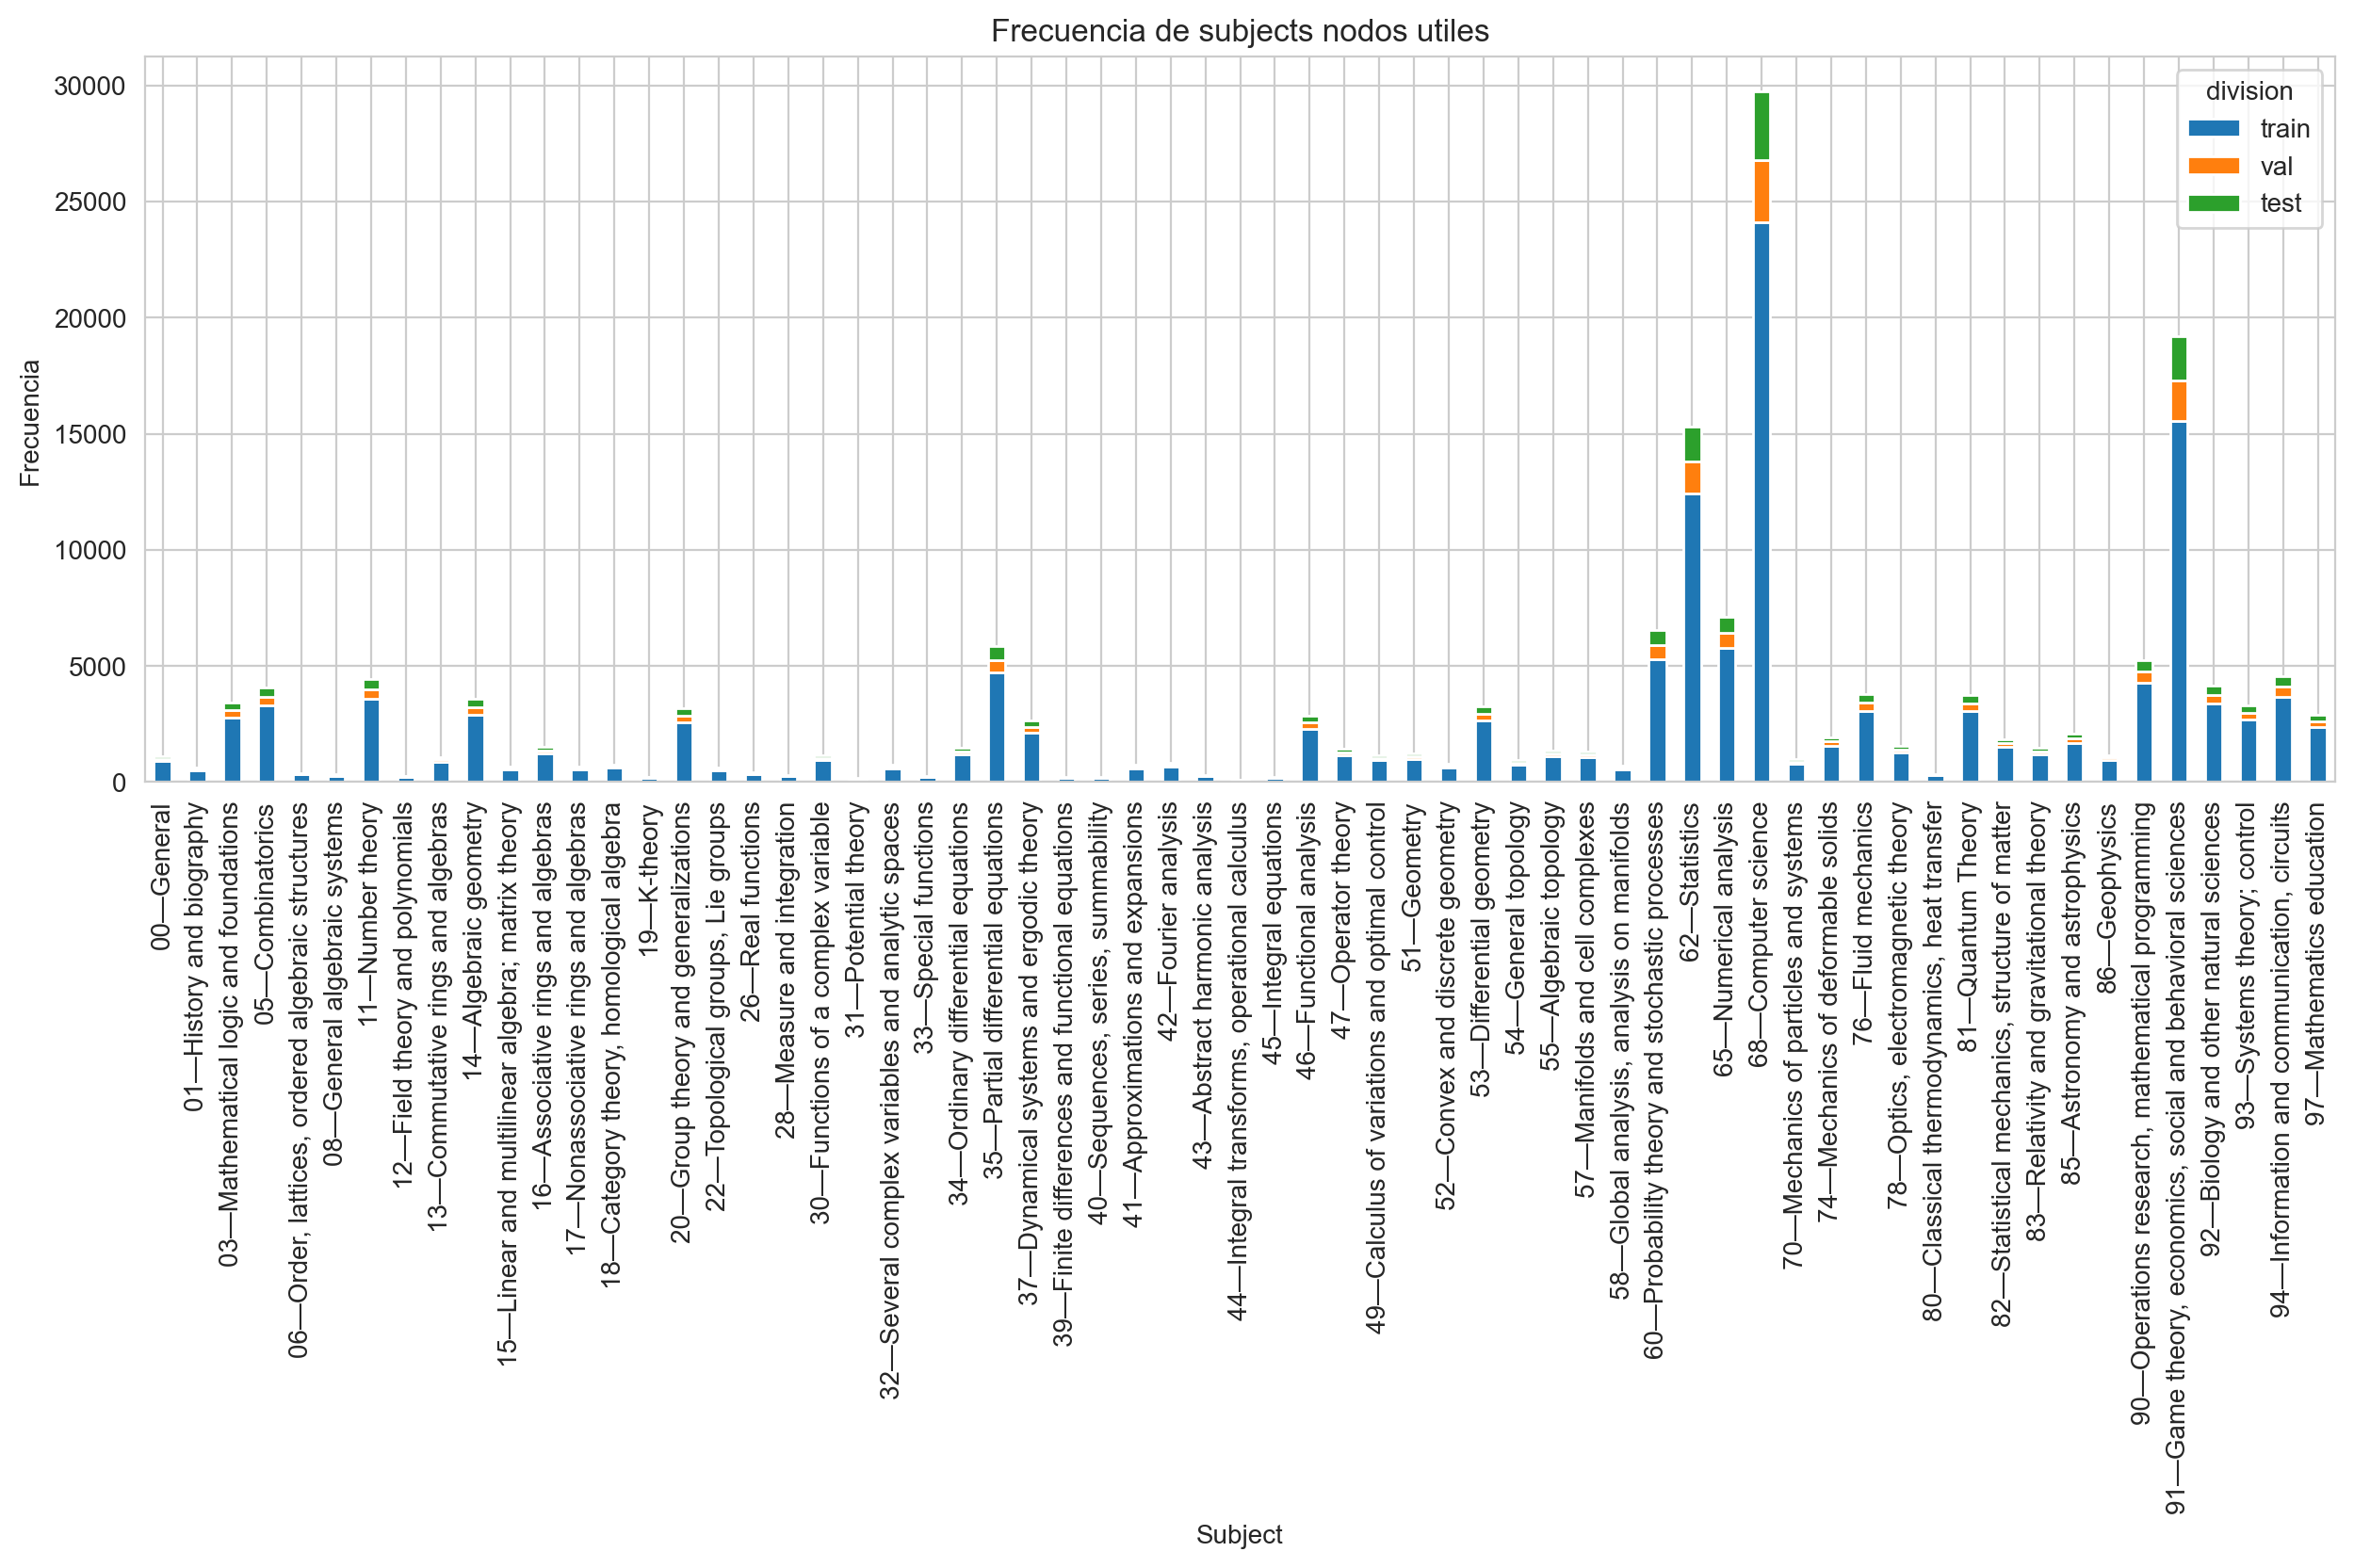

In [24]:
sns.set_style("whitegrid")

# hacer la figura de distribucion de etiquetas
fig, ax = plt.subplots(figsize=(15, 5), dpi = 200)

# pasar como pivot table
pivot_df = df_util.pivot_table(index='subject', columns='division', aggfunc='size')
# invertir el orden
pivot_df = pivot_df[pivot_df.columns[::-1]]
# cambiar el oden de las columnas
pivot_df = pivot_df[["train", "val", "test"]]
# hacer las barras
pivot_df.plot(kind='bar', stacked=True, ax=ax)

# titulos
ax.set_title('Frecuencia de subjects nodos utiles')
ax.set_xlabel('Subject')
ax.set_ylabel('Frecuencia')

plt.show()

In [25]:
# ver las clases con menos datos
pivot_df.sort_values('train').head()

division,train,val,test
subject,,,
"44—Integral transforms, operational calculus",77,9,10
31—Potential theory,134,15,16
45—Integral equations,163,18,20
"40—Sequences, series, summability",170,19,21
39—Finite differences and functional equations,175,20,22


## Ordenar y salvar resutlados

De todos los nodos, unicamente se consideran los nodos con tesis, que se divide en:

  * nodos_useless (nodos sin subject)

 *  nodos_train

 * nodos_val

 * nodos_test



In [26]:
assert len(nodos_useless) + len(nodos_train) + len(nodos_val) + len(nodos_test) == len(nodos_considerar)

In [27]:
# hacer un diccionario con toda la info
division_nodos = {
    'nodos_considerar' : [int(x) for x in nodos_considerar],
    'nodos_useless' : [int(x) for x in nodos_useless],
    'nodos_train' :[int(x) for x in nodos_train],
    'nodos_val' : [int(x) for x in nodos_val],
    'nodos_test' : [int(x) for x in nodos_test],
}

In [28]:
# salvar los datos 
with open(file_output_division, 'w') as outfile:
    json.dump(division_nodos, outfile)

# 2) Adapt data for probabilistic inference with our model

In [29]:
from tqdm import tqdm

In [30]:
# delimitar nombre de la carpeta donde se guardan los resultados
output_path = '.\\Probabilistic_Inference_data\\'

# nombre con que guardar el grafo para inferencia
name_graph_output = "data_graph.json"

## Filtrar solo nodos considerados en el grafo

In [31]:
# tomar los nodos considerados
nodos_a_usar = division_nodos['nodos_considerar']

# tomar un subgrafo solo con estos nodos
subgrafo = grafo.subgraph(nodos_a_usar).copy()

# considerar este subgrafo como todo el grafo
grafo = subgrafo

# volver a calcular
num_nodos = grafo.number_of_nodes()
num_aristas = grafo.number_of_edges()

print(f"Se filtran los nodos a considerar")
print("Info del nuevo grafo")
print(f"Se tienen {num_nodos} nodos")
print(f"Se tienen {num_aristas} aristas")

Se filtran los nodos a considerar
Info del nuevo grafo
Se tienen 267774 nodos
Se tienen 281288 aristas


## Mapear los subjects a indices

In [32]:
# tomar todos los id de los matematicos del grafo
ids_matematicos_grafo = grafo.nodes()

# primero, poner en una lista todos los subjects
# si no tiene subject (recordar que se tienen useless nodes, sin subject), poner que no se sabe
# notar que ya esta en el orden correcto
# es decir, en el mismo orden que los indices de nodos de 0 hasta n-1
subject_nodos = [grafo.nodes()[id_math]['subject'] 
                 if grafo.nodes()[id_math]['subject'] is not None
                 else "UNKNOWN"
                 for id_math in ids_matematicos_grafo]

print(f"Se toma los subjects de los {len(subject_nodos)} matematicos")

Se toma los subjects de los 267774 matematicos


In [33]:
# tomar todos los subjects unicos
subjects_unicos = list(set(subject_nodos))

# quitar el unknown
subjects_unicos.remove("UNKNOWN")

# poner al subject desconocido al final
subjects_unicos = sorted(subjects_unicos) + ["UNKNOWN"]

# ver cuantos son
num_clases = len(subjects_unicos) - 1    # poner -1 para no contar el unknow

print(f"Se tienen {num_clases} subjects diferentes (no se cuenta el unknown)")

Se tienen 63 subjects diferentes (no se cuenta el unknown)


In [34]:
# hacer el mapeo de indice a subject y viceversa

encode_subj_2_idx = {subj:idx for idx, subj in enumerate(subjects_unicos)} 
decode_idx_2_subj = {idx:subj for idx, subj in enumerate(subjects_unicos)}

In [35]:
# guardar estos diccionarios
with open(output_path + 'encode_subj_2_idx.pkl', 'wb') as f:
    pickle.dump(encode_subj_2_idx, f)
    
with open(output_path + 'decode_idx_2_subj.pkl', 'wb') as f:
    pickle.dump(decode_idx_2_subj, f)

In [36]:
# para cada nodo, agregar su label como atributo

# iterar en los nodos
for v, info_v in tqdm(grafo.nodes(data=True)):
    
    # tomar el label del nodo
    subject_math = info_v['subject']
    
    # si no tiene info
    if subject_math is None:
        # poner el UNKNOWN
        subject_math = "UNKNOWN"
        
    # poner el indice como argumento
    info_v['indice_subject'] = encode_subj_2_idx[subject_math]

100%|█████████████████████████████████████████████████████████████████████| 267774/267774 [00:00<00:00, 2344695.50it/s]


In [37]:
# ver que ya se tiene
grafo.nodes()[113798]

{'name': 'Christopher David Hollings',
 'thesis': 'Partial Actions of Semigroups and Monoids',
 'school': 'University of York',
 'country': 'UnitedKingdom',
 'year': '2007',
 'subject': '20—Group theory and generalizations',
 'indice_subject': 15}

## Identificar a que division pertenece cada nodo

Es decir, si es useless, train, val o test

In [38]:
# obtener los conjuntos de nodos, hacerlo conjunto
nodos_train = set(division_nodos['nodos_train'])
nodos_val = set(division_nodos['nodos_val'])
nodos_test = set(division_nodos['nodos_test'])
nodos_useless = set(division_nodos['nodos_useless'])

In [39]:
# para cada nodo, agregar su division como atributo

# iterar en los nodos
for v, info_v in tqdm(grafo.nodes(data=True)):
    
    # definir el estado de v de acuerod a su pertencencia
    
    # ver a donde pertenece
    if v in nodos_train:
        estado_v = "train"
        
    elif v in nodos_val:
        estado_v = "val"
    
    elif v in nodos_test:
        estado_v = "test"
        
    elif v in nodos_useless:
        estado_v = "useless"
        
    # si de casualidad no es de ninguna (deberia ser de alguna)
    else:
        raise ExceptionType(f"{v} no pertenece a ninguna division")
        
    
    # poner la division como argumento
    info_v['division'] = estado_v

100%|█████████████████████████████████████████████████████████████████████| 267774/267774 [00:00<00:00, 1939774.51it/s]


In [40]:
# ver que ya se tiene
grafo.nodes()[113798]

{'name': 'Christopher David Hollings',
 'thesis': 'Partial Actions of Semigroups and Monoids',
 'school': 'University of York',
 'country': 'UnitedKingdom',
 'year': '2007',
 'subject': '20—Group theory and generalizations',
 'indice_subject': 15,
 'division': 'train'}

## Solo conservar informacion de interes

thesis, indice_subject y division

In [41]:
# delimitarlos
atributos_considerar = ["thesis", "indice_subject", "division"]

In [42]:
# crear un grafo nuevo
grafo_limpio = nx.DiGraph()

# pasar los nodos al nuevo grafo, solo los atributos de interes
for v, info_v in tqdm(grafo.nodes(data=True)):
    
    # filtrar atributos
    atributos_v = {atrr: info_v[atrr] for atrr in atributos_considerar}
    
    # añadir este nodo al nuevo grafo
    grafo_limpio.add_node(v, **atributos_v)

# copiar las aristas
grafo_limpio.add_edges_from(grafo.edges(data=True))

# volver a calcular, deberia ser lo mismo
num_nodos = grafo_limpio.number_of_nodes()
num_aristas = grafo_limpio.number_of_edges()

print(f"Se tienen {num_nodos} nodos")
print(f"Se tienen {num_aristas} aristas")

100%|██████████████████████████████████████████████████████████████████████| 267774/267774 [00:00<00:00, 462308.78it/s]


Se tienen 267774 nodos
Se tienen 281288 aristas


In [43]:
# ver que se tiene
grafo_limpio.nodes()[113798]

{'thesis': 'Partial Actions of Semigroups and Monoids',
 'indice_subject': 15,
 'division': 'train'}

In [44]:
# ver que se tiene
grafo_limpio.nodes()[6974]

{'thesis': 'On Knots, with a Census of the Amphericheirals with Twelve Crossings',
 'indice_subject': 63,
 'division': 'useless'}

## Guardar grafo para ser usado por inferencia

In [45]:
# guardar el grafo
with open(output_path + name_graph_output, 'wb') as f:
    pickle.dump(grafo_limpio, f)

# 3) Adapt data for text classification

Create the csv files that will be used to perform text classification

In [46]:
# direccion donde poner los archivos creados
output_path = ".\\Text_classification_data\\"

In [47]:
# volver a cargar el grafo original
grafo = grafo_original.copy()

# responder preguntas basicas
num_nodos = grafo.number_of_nodes()

print(f"Se tienen {num_nodos} nodos")

Se tienen 297377 nodos


### Funcion auxiliar

In [48]:
# dado un conjunto de nodos
# crear un csv con tesis y subject
def crear_datos_nodos(nodos_interes, output_path_and_name, keep_subject = True):
    
    # tomar las tesis y subject
    tesis_nodos = [grafo.nodes()[v]['thesis'] for v in nodos_interes]
    subject_nodos = [grafo.nodes()[v]['subject'] for v in nodos_interes]
        
    # crear df
    df = pd.DataFrame()

    # poner info
    df['thesis'] = tesis_nodos
    
    # subject solo si se quiere
    if keep_subject:
        df['subject'] = subject_nodos
        
    # el indice de los nodos
    df.index = nodos_interes

    print(f"Data Frame creado con {df.shape[0]} filas")
    
    # guardar
    df.to_csv(output_path_and_name, encoding='utf-8-sig', index=True)

## Crear conjuntos de datos

In [49]:
# train
crear_datos_nodos(division_nodos['nodos_train'], output_path + "train_df.csv")

Data Frame creado con 141345 filas


In [50]:
# val
crear_datos_nodos(division_nodos['nodos_val'], output_path + "val_df.csv")

Data Frame creado con 15705 filas


In [51]:
# test
crear_datos_nodos(division_nodos['nodos_test'], output_path + "test_df.csv")

Data Frame creado con 17451 filas


In [52]:
# todos los nodos considerados (concatenacion de las 3 de arriba mas los unknown)
crear_datos_nodos(division_nodos['nodos_considerar'], output_path + "full_df.csv", keep_subject = False)

Data Frame creado con 267774 filas


In [53]:
# ejemplo de como cargar un df creado con esta funcion
df_loaded = pd.read_csv(output_path + "full_df.csv", encoding='utf-8-sig', index_col=0, na_values=None, keep_default_na=False)
df_loaded.head()

,thesis
255897,Spatial Modeling of Activity and User Assistan...
206917,The Purchasing Power Theories of Trade Unions
113793,Stroomverdeeling in versterkerbuizen
113794,Uitbreiding van electromagnetische golven en e...
113795,Spanningsregeling van electrische machines doo...


# 4) Adapt data for GNN

Create the graph that will be used to clasify subjects with GNN.



Tomar el grafo con la informacion de math genealogy project. Ponerlos en buen formato para despues usar pytorch geometric. 

Los features de cada nodo vienen de aplicar tf-idf o binarizacion a la tesis. Las target variables son los subjects.

In [54]:
from collections import Counter
import torch
from torch_geometric.data import Data

In [55]:
# delimitar nombre de la carpeta donde se guardan los resultados
output_path = '.\\GNN_data\\'

In [56]:
# responder preguntas basicas
num_nodos = grafo.number_of_nodes()
num_aristas = grafo.number_of_edges()


print(f"Se tienen {num_nodos} nodos")
print(f"Se tienen {num_aristas} aristas")

Se tienen 297377 nodos
Se tienen 329209 aristas


## Filtrar solo nodos considerados

Es decir, nodos con tesis

In [57]:
# tomar los nodos considerados
nodos_a_usar = division_nodos['nodos_considerar']

# tomar un subgrafo solo con estos nodos
subgrafo = grafo.subgraph(nodos_a_usar).copy()

# considerar este subgrafo como todo el grafo
grafo = subgrafo

# volver a calcular
num_nodos = grafo.number_of_nodes()
num_aristas = grafo.number_of_edges()

print(f"Se filtran los nodos a considerar")
print("Info del nuevo grafo")
print(f"Se tienen {num_nodos} nodos")
print(f"Se tienen {num_aristas} aristas")

Se filtran los nodos a considerar
Info del nuevo grafo
Se tienen 267774 nodos
Se tienen 281288 aristas


# Crear un objeto data con la informacion del grafo

A single graph in PyG is described by an instance of torch_geometric.data.Data, which holds the following attributes by default:

data.x: Node feature matrix with shape [num_nodes, num_node_features]


data.y: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]


data.edge_index: Graph connectivity in COO format with shape [2, num_edges] and type torch.long


## 1) Mapeo de indices de nodos

Se espera que los indices de los nodos que vayan de 0 a n-1, donde n es el numero de nodos.

Acualmente, se tiene el id del matematico en cada nodo.

Hacer un mapeo que lleve del id del matematico a cada node id

In [58]:
# tomar todos los id de los matematicos del grafo
ids_matematicos_grafo = grafo.nodes()

# ver que si
assert len(ids_matematicos_grafo) == num_nodos

print(f"Se tienen {len(ids_matematicos_grafo)} nodos")

Se tienen 267774 nodos


In [59]:
# hacer el diccionario que va de id de matematico a id de nodo
encode_mathid_2_nodeid = {mathid: idx for idx, mathid in enumerate(ids_matematicos_grafo)}

# hacer el indice que va de id de nodo a id de matematico
decode_nodeid_2_mathid = {idx: mathid for idx, mathid in enumerate(ids_matematicos_grafo)}

In [60]:
# guardar estos diccionarios
with open(output_path + 'encode_mathid_2_nodeid.pkl', 'wb') as f:
    pickle.dump(encode_mathid_2_nodeid, f)
    
with open(output_path + 'decode_nodeid_2_mathid.pkl', 'wb') as f:
    pickle.dump(decode_nodeid_2_mathid, f)

## 2) Obtener los node features 

Se exploran dos opciones, 1500 features, o todo el vocabulario

In [61]:
# primero, poner en una lista todas las thesis
# notar que ya esta en el orden correcto
# es decir, en el mismo orden que los indices de nodos de 0 hasta n-1
tesis_nodos = [grafo.nodes()[id_math]['thesis'] 
               for id_math in ids_matematicos_grafo]

print(f"Se toma la tesis de los {len(tesis_nodos)} matematicos")

Se toma la tesis de los 267774 matematicos


## 2.1) Binary features (1500)

In [62]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import coo_matrix


# vectorizar estas oraciones para tener los node features

# insanciar el pesado
vectorizer = CountVectorizer(stop_words='english', max_features=1500, binary=True) # basandome en CORA

# vectorizar
X1 =  vectorizer.fit_transform(tesis_nodos)
print(X1.shape)

# identificar los atributos
coo = coo_matrix(X1)
indices = torch.tensor([coo.row, coo.col], dtype=torch.int64)
values = torch.tensor(coo.data, dtype=torch.float32)
shape = torch.Size(coo.shape)

#  Mantener formato esparso y convertir a tensor
X1 = torch.sparse_coo_tensor(indices, values, shape)


# ver que si
assert X1.shape[0] == num_nodos

print(f"Forma de los node atributes small = {X1.shape}")

(267774, 1500)
Forma de los node atributes small = torch.Size([267774, 1500])


C:\Users\diego\AppData\Local\Temp\ipykernel_26652\2266280442.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:278.)
  indices = torch.tensor([coo.row, coo.col], dtype=torch.int64)


## 2.1) Binary features (unlimited)

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix


# vectorizar estas oraciones para tener los node features

# insanciar el pesado
vectorizer = CountVectorizer(stop_words='english', binary=True)

# vectorizar
X2 =  vectorizer.fit_transform(tesis_nodos)
print(X2.shape)

# identificar los atributos
coo = coo_matrix(X2)
indices = torch.tensor([coo.row, coo.col], dtype=torch.int64)
values = torch.tensor(coo.data, dtype=torch.float32)
shape = torch.Size(coo.shape)

#  Mantener formato esparso y convertir a tensor
X2 = torch.sparse_coo_tensor(indices, values, shape)

# ver que si
assert X2.shape[0] == num_nodos

print(f"Forma de los node atributes big = {X2.shape}")

(267774, 108672)
Forma de los node atributes big = torch.Size([267774, 108672])


## 3) Obtener las target

Las etiquetas de los target se ponen con numeros, se debe definir el mapeo.

Recordar que ya se tienen los mapeos: encode_subj_2_idx y decode_idx_2_subj

In [64]:
# guardar estos diccionarios que ya se tienen en la carpeta de GNN
with open(output_path + 'encode_subj_2_idx.pkl', 'wb') as f:
    pickle.dump(encode_subj_2_idx, f)
    
with open(output_path + 'decode_idx_2_subj.pkl', 'wb') as f:
    pickle.dump(decode_idx_2_subj, f)

In [65]:
# tomar la etiqueta de cada nodo, el indice correcto
y = np.array([encode_subj_2_idx[subj] for subj in subject_nodos])

# ponerlo en formato correcto
y = torch.from_numpy(y)

# ver que si
assert y.shape[0] == num_nodos

print(f"Forma de los target = {y.shape}")

Forma de los target = torch.Size([267774])


## 4) Obtener el edge index

In [66]:
# iterar en los edges y guardar los indices de los nodos
# no los indices de los matematicos
edges_index = [(encode_mathid_2_nodeid[u], encode_mathid_2_nodeid[v]) for (u, v) in grafo.edges()]

# pasar a formato correcto
edges_index = np.array(edges_index)
edges_index = torch.from_numpy(edges_index)
edges_index = edges_index.T

# ver que si
assert edges_index.shape[1] == num_aristas

print(f"Forma del edge index = {edges_index.shape}")

Forma del edge index = torch.Size([2, 281288])


## Salvar los componentes del data: features, edge index, y

In [67]:
# salvar todos los componentes
torch.save(X1, output_path + 'node_features_small.pt') # salvar node features de 1500
torch.save(X2, output_path + 'node_features_big.pt') # salvar node features sin restriccion
torch.save(edges_index, output_path + 'edge_index.pt')
torch.save(y, output_path + 'y.pt')

## Obtener los mask

Los mask se usan para identificar los nodos que son usados para entrenamiento, validacion o prueba. Tambien los que no tienen subject.

In [68]:
# obtener los conjuntos de nodos
# donde se usa el math id 
nodos_train_math_id = division_nodos['nodos_train']
nodos_val_math_id = division_nodos['nodos_val']
nodos_test_math_id = division_nodos['nodos_test']
nodos_useless_math_id = division_nodos['nodos_useless']

In [69]:
# ahora considera id del nodo, no del matematico
nodos_train_id = torch.tensor([encode_mathid_2_nodeid[mathid] for mathid in nodos_train_math_id])
nodos_val_id = torch.tensor([encode_mathid_2_nodeid[mathid] for mathid in nodos_val_math_id])
nodos_test_id = torch.tensor([encode_mathid_2_nodeid[mathid] for mathid in nodos_test_math_id])
nodos_useless_id = torch.tensor([encode_mathid_2_nodeid[mathid] for mathid in nodos_useless_math_id])

In [70]:
from torch_geometric.utils import index_to_mask


# ya se tienen los train, val y test nodes, hacer las masks
train_mask = index_to_mask(nodos_train_id, size = num_nodos)
val_mask = index_to_mask(nodos_val_id, size = num_nodos)
test_mask = index_to_mask(nodos_test_id, size = num_nodos)
useless_mask = index_to_mask(nodos_useless_id, size = num_nodos)

In [71]:
# ver los porcentajes creados
print(f"Train mask: {train_mask.sum().item()} nodos - {round(100*train_mask.sum().item()/num_nodos, 2)}%")
print(f"Val mask: {val_mask.sum().item()} nodos - {round(100*val_mask.sum().item()/num_nodos, 2)}%")
print(f"Test mask: {test_mask.sum().item()} nodos - {round(100*test_mask.sum().item()/num_nodos, 2)}%")
print(f"\nUseless mask: {useless_mask.sum().item()} nodos - {round(100*useless_mask.sum().item()/num_nodos, 2)}%")

Train mask: 141345 nodos - 52.79%
Val mask: 15705 nodos - 5.87%
Test mask: 17451 nodos - 6.52%

Useless mask: 93273 nodos - 34.83%


In [72]:
# ver si los mask consideran todos las clases o no


# obtener el numero de subjects diferentes de cada mask
useless_mask_subjects = len(np.unique(y[useless_mask].numpy()))
train_mask_subjects = len(np.unique(y[train_mask].numpy()))
val_mask_subjects = len(np.unique(y[val_mask].numpy()))
test_mask_subjects = len(np.unique(y[test_mask].numpy()))

# ver
print(f"En total se tienen {num_clases} clasificaciones (sin el unknown)")

print(f"\nNumero de clasificaciones diferentes en useless mask: {useless_mask_subjects}")
print(f"Numero de clasificaciones diferentes en train mask: {train_mask_subjects}")
print(f"Numero de clasificaciones diferentes en val mask: {val_mask_subjects}")
print(f"Numero de clasificaciones diferentes en test mask: {test_mask_subjects}")

En total se tienen 63 clasificaciones (sin el unknown)

Numero de clasificaciones diferentes en useless mask: 1
Numero de clasificaciones diferentes en train mask: 63
Numero de clasificaciones diferentes en val mask: 63
Numero de clasificaciones diferentes en test mask: 63


In [73]:
# salvar todos los masks
torch.save(train_mask, output_path + 'train_mask.pt')
torch.save(val_mask, output_path + 'val_mask.pt')
torch.save(test_mask, output_path + 'test_mask.pt')
torch.save(useless_mask, output_path + 'useless_mask.pt')

## Ejemplo de como cargar todos los datos

In [74]:
# teniendo la carpeta correcta
carpeta_lectura_datos = output_path

In [75]:
# cargar los diccionarios de codificacion de id

with open(carpeta_lectura_datos + 'encode_mathid_2_nodeid.pkl', 'rb') as f:
    encode_mathid_2_nodeid = pickle.load(f)
    
with open(carpeta_lectura_datos + 'decode_nodeid_2_mathid.pkl', 'rb') as f:
    decode_nodeid_2_mathid = pickle.load(f)

In [76]:
# cargar los diccionarios de codificacion de subject
with open(carpeta_lectura_datos + 'encode_subj_2_idx.pkl', 'rb') as f:
    encode_subj_2_idx = pickle.load(f)
    
with open(carpeta_lectura_datos + 'decode_idx_2_subj.pkl', 'rb') as f:
    decode_idx_2_subj = pickle.load(f)

In [77]:
# cargar features, edge index, y

X = torch.load(carpeta_lectura_datos + 'node_features_big.pt') # se puede cambiar (node_features_small, node_features_big)
edge_index = torch.load(carpeta_lectura_datos + 'edge_index.pt')
y =  torch.load(carpeta_lectura_datos + 'y.pt')

In [78]:
# cargar masks
train_mask = torch.load(carpeta_lectura_datos + 'train_mask.pt')
val_mask = torch.load(carpeta_lectura_datos + 'val_mask.pt')
test_mask = torch.load(carpeta_lectura_datos + 'test_mask.pt')
useless_mask = torch.load(carpeta_lectura_datos + 'useless_mask.pt')

In [79]:
# crear el objeto data
data = Data(X = X, y = y, edge_index = edge_index)

# poner el numero de nodos
data.num_nodes = X.shape[0]

# comprobar
assert X.shape[0] == y.shape[0]

# agregar los masks
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask
data.useless_mask = useless_mask

# ver que este bien
data.validate(raise_on_error=True)

data

Data(edge_index=[2, 281288], y=[267774], X=[267774, 108672], num_nodes=267774, train_mask=[267774], val_mask=[267774], test_mask=[267774], useless_mask=[267774])

In [80]:
# ver unas cosas del grafo

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

print(f'\nNumber of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')

print(f'\nNumber of validating nodes: {data.val_mask.sum()}')
print(f'Validation node label rate: {int(data.val_mask.sum()) / data.num_nodes:.2f}')

print(f'\nNumber of testing nodes: {data.test_mask.sum()}')
print(f'Testing node label rate: {int(data.test_mask.sum()) / data.num_nodes:.2f}')

print(f'\nNumber of useless nodes: {data.useless_mask.sum()}')
print(f'Useless node label rate: {int(data.useless_mask.sum()) / data.num_nodes:.2f}')

Number of nodes: 267774
Number of edges: 281288
Average node degree: 1.05
Has isolated nodes: True
Has self-loops: False
Is undirected: False

Number of training nodes: 141345
Training node label rate: 0.53

Number of validating nodes: 15705
Validation node label rate: 0.06

Number of testing nodes: 17451
Testing node label rate: 0.07

Number of useless nodes: 93273
Useless node label rate: 0.35
